In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import numpy as np
from typing import List, Tuple
import pickle
from torch.utils.data import ConcatDataset, Dataset, Subset
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]
import time

In [2]:
train_dataset = CIFAR10('/home/vishal1/Desktop/nitin/AAMAS_Exp/CIFAR10', train=True, download=False, transform=transforms.ToTensor())
test_dataset = CIFAR10('/home/vishal1/Desktop/nitin/AAMAS_Exp/CIFAR10', train=False, download=False, transform=transforms.ToTensor())

In [3]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
classes = 10
input_dim = 784
num_clients = 10
rounds = 30
batch_size = 32
in_group_rounds=3
epochs_per_client =2
learning_rate = 2e-2
num_malicious_clients=5
lambda_value=0.001

In [4]:
total_train_size, total_test_size

(50000, 10000)

In [5]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()


def average_models(new_model, next, scale):
    if new_model == None:
        new_model = next
        for key in new_model:
            new_model[key] = new_model[key] * scale
    else:
        for key in new_model:
            new_model[key] = new_model[key] + (next[key] * scale)
    return new_model

In [6]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        # Update input channels to 3 for RGB images
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.fc = torch.nn.Linear(8 * 8 * 32, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr,lambdavalue,global_model, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                proximal_term = 0
                for param, global_param in zip(self.parameters(), global_model.parameters()):
                    proximal_term += torch.sum(torch.pow(param - global_param.data, 2))
                loss += (lambdavalue / 2) * proximal_term
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [7]:
def partition_data_label_quantity(
    num_clients, labels_per_client, train_dataset,total_train_size,seed=42):
    trainset=train_dataset
    prng = np.random.default_rng(seed)

    targets = trainset.targets
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(targets, torch.Tensor):
        targets = targets.numpy()
    num_classes = len(set(targets))
    times = [0 for _ in range(num_classes)]
    contains = []

    for i in range(num_clients):
        current = [i % num_classes]
        times[i % num_classes] += 1
        j = 1
        while j < labels_per_client:
            index = prng.choice(num_classes, 1)[0]
            if index not in current:
                current.append(index)
                times[index] += 1
                j += 1
        contains.append(current)
    idx_clients: List[List] = [[] for _ in range(num_clients)]
    for i in range(num_classes):
        idx_k = np.where(targets == i)[0]
        prng.shuffle(idx_k)
        idx_k_split = np.array_split(idx_k, times[i])
        ids = 0
        for j in range(num_clients):
            if i in contains[j]:
                idx_clients[j] += idx_k_split[ids].tolist()
                ids += 1
    trainsets_per_client = [Subset(trainset, idxs) for idxs in idx_clients]
    return trainsets_per_client

In [8]:
client_datasets = partition_data_label_quantity(num_clients,2,train_dataset,len(train_dataset))

FL

In [9]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict,global_net):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, lambda_value,global_net,batch_size)
        return net.state_dict()

In [10]:
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [11]:
fl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
history_FL = []
traffic=[]
weights=[]
load_model=None
total_length_dataset=len(train_dataset)
for i in range(rounds):
    curr_parameters = global_net.state_dict()
    new_model=None
    for client in clients:
        client_parameters = client.train(curr_parameters, global_net)
        fraction = client.get_dataset_size()/total_length_dataset
        new_model=average_models(new_model,client_parameters,fraction)
    load_model=new_model.copy()
    params = list(load_model)
    total_norm = 0.0
    for key, value in load_model.items():
        total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(new_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append(2*num_clients)
    history_FL.append((train_acc, dev_acc,i))

fl_end_time = time.time()
fl_time = fl_end_time - fl_start_time

After round 1, train_loss = 2.4147, dev_loss = 2.4221, dev_acc = 0.1327

After round 2, train_loss = 2.0225, dev_loss = 2.0284, dev_acc = 0.2604

After round 3, train_loss = 1.8782, dev_loss = 1.8855, dev_acc = 0.307

After round 4, train_loss = 1.7931, dev_loss = 1.8041, dev_acc = 0.3427

After round 5, train_loss = 1.6919, dev_loss = 1.7065, dev_acc = 0.3893

After round 6, train_loss = 1.6444, dev_loss = 1.6633, dev_acc = 0.4013

After round 7, train_loss = 1.6148, dev_loss = 1.6389, dev_acc = 0.4122

After round 8, train_loss = 1.5609, dev_loss = 1.5883, dev_acc = 0.4283

After round 9, train_loss = 1.5134, dev_loss = 1.5428, dev_acc = 0.446

After round 10, train_loss = 1.5264, dev_loss = 1.5583, dev_acc = 0.437

After round 11, train_loss = 1.4617, dev_loss = 1.4974, dev_acc = 0.4639

After round 12, train_loss = 1.4351, dev_loss = 1.4716, dev_acc = 0.4708

After round 13, train_loss = 1.406, dev_loss = 1.4458, dev_acc = 0.4802

After round 14, train_loss = 1.4072, dev_loss = 1.4

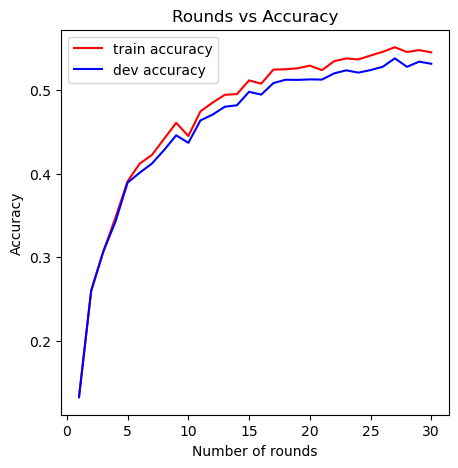

In [12]:
plt.plot([i + 1 for i in range(len(history_FL))], [history_FL[i][0] for i in range(len(history_FL))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_FL))], [history_FL[i][1] for i in range(len(history_FL))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

DFL

In [13]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
        self.client_data=[]
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict, global_net):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, lambda_value,global_net, batch_size)
        return net.state_dict()
    
    def recieve_parameters(self,client_id,client_parameter,fraction):
        client_object={"client_id":client_id,"client_parameter":client_parameter,"fraction":fraction}
        self.client_data.append(client_object)

    def aggregated_parameters(self):
            local_aggregated_model=None
            for i in range(0,len(self.client_data)):
                 local_aggregated_model=average_models(local_aggregated_model,self.client_data[i]["client_parameter"],self.client_data[i]["fraction"])
            self.client_data.clear()
            return local_aggregated_model

In [14]:
clients = [Client(i, client_datasets[i]) for i in range(num_clients)]

In [15]:
dfl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_DFL = []
weights=[]
traffic=[]
load_model=None
total_data_size=len(train_dataset)
for i in range(rounds):
    new_model=None
    for client in clients:
        fraction = client.get_dataset_size()/total_data_size
        if i == 0:
            client_parameters=client.train(curr_parameters, global_net)
        else:
            client_parameters = client.train(client.aggregated_parameters(), global_net)
        for clt in clients:
                clt.recieve_parameters(client.get_client_id(),client_parameters,fraction)
        new_model=average_models(new_model,client_parameters,fraction)
    


    load_model=new_model.copy()
    params = list(load_model)
    total_norm = 0.0
    for key, value in load_model.items():
            total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(new_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append((num_clients)*(num_clients-1))
    history_DFL.append((train_acc, dev_acc,i))

dfl_end_time = time.time()
dfl_time = dfl_end_time - dfl_start_time

After round 1, train_loss = 2.2979, dev_loss = 2.2998, dev_acc = 0.1358

After round 2, train_loss = 2.0729, dev_loss = 2.0706, dev_acc = 0.2424

After round 3, train_loss = 1.7087, dev_loss = 1.7195, dev_acc = 0.3628

After round 4, train_loss = 1.5979, dev_loss = 1.614, dev_acc = 0.4037

After round 5, train_loss = 1.5909, dev_loss = 1.6112, dev_acc = 0.4142

After round 6, train_loss = 1.5286, dev_loss = 1.5533, dev_acc = 0.4376

After round 7, train_loss = 1.5136, dev_loss = 1.5411, dev_acc = 0.4442

After round 8, train_loss = 1.5083, dev_loss = 1.5381, dev_acc = 0.4436

After round 9, train_loss = 1.4821, dev_loss = 1.5154, dev_acc = 0.4606

After round 10, train_loss = 1.4716, dev_loss = 1.5066, dev_acc = 0.4528

After round 11, train_loss = 1.4411, dev_loss = 1.4774, dev_acc = 0.4707

After round 12, train_loss = 1.3974, dev_loss = 1.4364, dev_acc = 0.4884

After round 13, train_loss = 1.3738, dev_loss = 1.4119, dev_acc = 0.4978

After round 14, train_loss = 1.3854, dev_loss = 

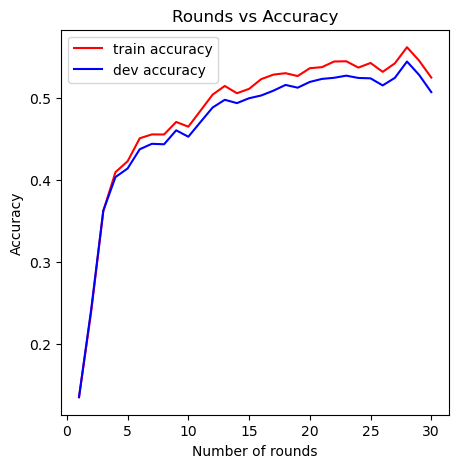

In [16]:
plt.plot([i + 1 for i in range(len(history_DFL))], [history_DFL[i][0] for i in range(len(history_DFL))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_DFL))], [history_DFL[i][1] for i in range(len(history_DFL))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

HDFL

In [17]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
        self.client_data=[]
        self.server_id=-1
        self.distance=random.randint(1,100)
        self.client_data_server=[]
    
    def set_server_id(self,client_id):
        self.client_data_server=[]
        self.server_id=client_id
    
    def get_server_id(self):
        return self.server_id
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict, global_net):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, lambda_value,global_net, batch_size)
        # print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.state_dict()
    
    def recieve_parameters(self,client_id,client_parameter,fraction):
        client_object={"client_id":client_id,"client_parameter":client_parameter,"fraction":fraction}
        self.client_data.append(client_object)

    def aggregated_parameters(self):
            local_aggregated_model=None
            for i in range(0,len(self.client_data)):
                 local_aggregated_model=average_models(local_aggregated_model,self.client_data[i]["client_parameter"],self.client_data[i]["fraction"])
            self.client_data.clear()
            return local_aggregated_model
    
    def recieve_data_as_server(self,client_parameter,fraction):
        client_object={"client_parameter":client_parameter,"fraction":fraction}
        self.client_data_server.append(client_object)
    

    def aggregate_parameter_as_server(self):
         local_aggregated_model_as_server=None
         for data in self.client_data_server:
              local_aggregated_model_as_server=average_models(local_aggregated_model_as_server,data["client_parameter"],data["fraction"])
         self.client_data_server.clear()
         return local_aggregated_model_as_server   

In [18]:
def utility_function(client_set_1,client_set_2,data):
  client_set_1_average=None
  client_set_2_average=None
  for i in client_set_1:
    client_set_1_average=average_models(client_set_1_average,data[i],1)
  for i in client_set_2:
    client_set_2_average=average_models(client_set_2_average,data[i],1)
  model1_weights = []
  model2_weights = []
  for key, value in client_set_1_average.items():
      model1_weights.append(value.detach().cpu())

  for key, value in client_set_2_average.items():
      model2_weights.append(value.detach().cpu())
  weight1_flat = torch.cat([param.view(-1) for param in model1_weights])
  weight2_flat = torch.cat([param.view(-1) for param in model2_weights])
  cosine_sim = torch.nn.functional.cosine_similarity(weight1_flat, weight2_flat, dim=0)
  return cosine_sim.item()

In [19]:
def generateGroupsGame(data,num_clients):
    groups=[]
    for i in range(0,num_clients):
        groups.append([i])
    while True:
        for group in groups:
            for x in group:
                no_change_flag=0
                m_i_n_group=None
                m_i_n_utility=100
                for g in groups:
                    if g!=group:
                        if len(g) >= 1 and len(group) > 1:
                            tempset_1=g.copy()
                            tempset_1.append(x)
                            tempset_2=group.copy()
                            tempset_2.remove(x)
                            if utility_function(tempset_1,tempset_2,data) > utility_function(g,group,data): 
                                if m_i_n_utility > utility_function(tempset_1,tempset_2,data):
                                    m_i_n_group=g
                                    m_i_n_utility=utility_function(tempset_1,tempset_2,data)        
                        elif len(group)<=1:
                            if utility_function(g,group,data) < m_i_n_utility:
                                m_i_n_group=g
                                m_i_n_utility=utility_function(g,group,data)
                if m_i_n_group is not None:  
                    group.remove(x)
                    m_i_n_group.append(x)
                    no_change_flag=1
                    if len(group) <=0 :
                        groups.remove(group)
        if no_change_flag == 0:
            break
    print("end")
    return groups

In [20]:
def groupDataLength(groups,clients):
    group_dataset_length=[]
    for grp in groups:
        totalcount=0
        for clt in grp:
            totalcount+=clients[clt].get_dataset_size()
        group_dataset_length.append(totalcount)
    return group_dataset_length

In [21]:
clients = [Client(i, client_datasets[i]) for i in range(num_clients)]

In [22]:
global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
data = []
for client in clients:
    paramerter=client.train(curr_parameters,global_net)
    data.append(paramerter)

In [23]:
groups=generateGroupsGame(data,num_clients)
print(groups)
group_dataset_length=groupDataLength(groups,clients)

end
[[6, 8, 4, 9], [7, 1], [2, 3, 5, 0]]


In [24]:
hdfl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_HDFL = []
weights=[]
traffic=[]
load_model=None
total_dataset_length=len(train_dataset)
flag=True
for i in range(rounds):
    traffic_single_sum=0
    server=[]
    for grp in groups:
        traffic_single_sum=traffic_single_sum+len(grp)-1
        server_id=np.random.choice(grp,p=np.ones(len(grp))/len(grp))
        server.append(server_id)
        clients[server_id].set_server_id(server_id)
    k=0
    for grp in groups:
        flag=True
        for j in range(in_group_rounds):
            traffic_single_sum=traffic_single_sum+((len(grp)-1)*len(grp))
            for clt in grp:
                fraction = clients[clt].get_dataset_size()/group_dataset_length[k]
                if i == 0 and flag : #at the very start train using initial global model param
                    client_parameters=clients[clt].train(curr_parameters, global_net) 
                elif j == 0: #in subsequent rounds, use load_model at the start of in group rounds
                    client_parameters=clients[clt].train(load_model, global_net) 
                else: #In other scenarios, use aggregated models
                    client_parameters = clients[clt].train(clients[clt].aggregated_parameters(), global_net)
                for clt_1 in grp: #transfer the current client's learned parameters to all clients (including itself) => to be used for aggregation in each client
                        clients[clt_1].recieve_parameters(clt_1,client_parameters,fraction)
            flag=False
        #aggregating on the random choosn server
        for clt in grp:
                fraction = clients[clt].get_dataset_size()/group_dataset_length[k]
                t=clients[clt].aggregated_parameters()
                clients[server[k]].recieve_data_as_server(t,fraction)
        k+=1
    #aggregating the parameters
    aggregateds=[]
    for clt in server:
            t=clients[clt].aggregate_parameter_as_server()
            aggregateds.append(t)
    #choosing the server from the amongst server at unifrom probability
    server_id=np.random.choice(server,p=np.ones(len(server))/len(server))
    clients[server_id].set_server_id(server_id)
    traffic_single_sum=traffic_single_sum+len(server)
    #sending the data to the chosen from all the group server
    group_number=0
    for clt in aggregateds:
            fraction=group_dataset_length[group_number]/total_dataset_length
            group_number+=1
            clients[server_id].recieve_data_as_server(clt,fraction)
    #aggregating at the top level server
    traffic_single_sum=traffic_single_sum+num_clients        
    aggregated_parameters_top=clients[server_id].aggregate_parameter_as_server()
    load_model=aggregated_parameters_top.copy()
    total_norm = 0.0
    for key, value in load_model.items():
            total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(load_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append(traffic_single_sum)
    history_HDFL.append((train_acc, dev_acc,i))

hdfl_end_time = time.time()
hdfl_time = hdfl_end_time - hdfl_start_time

After round 1, train_loss = 2.183, dev_loss = 2.1808, dev_acc = 0.2215

After round 2, train_loss = 1.9227, dev_loss = 1.9266, dev_acc = 0.2651

After round 3, train_loss = 1.7512, dev_loss = 1.7655, dev_acc = 0.3727

After round 4, train_loss = 1.6375, dev_loss = 1.6596, dev_acc = 0.3995

After round 5, train_loss = 1.5729, dev_loss = 1.6051, dev_acc = 0.4233

After round 6, train_loss = 1.518, dev_loss = 1.557, dev_acc = 0.4425

After round 7, train_loss = 1.4757, dev_loss = 1.5269, dev_acc = 0.4461

After round 8, train_loss = 1.4072, dev_loss = 1.4684, dev_acc = 0.4771

After round 9, train_loss = 1.369, dev_loss = 1.4391, dev_acc = 0.4858

After round 10, train_loss = 1.3514, dev_loss = 1.4336, dev_acc = 0.4908

After round 11, train_loss = 1.3273, dev_loss = 1.4211, dev_acc = 0.4982

After round 12, train_loss = 1.3257, dev_loss = 1.4329, dev_acc = 0.4943

After round 13, train_loss = 1.3089, dev_loss = 1.4266, dev_acc = 0.5031

After round 14, train_loss = 1.3063, dev_loss = 1.4

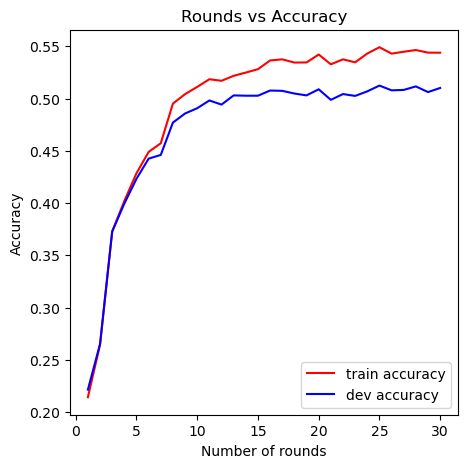

In [25]:
plt.plot([i + 1 for i in range(len(history_HDFL))], [history_HDFL[i][0] for i in range(len(history_HDFL))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_HDFL))], [history_HDFL[i][1] for i in range(len(history_HDFL))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

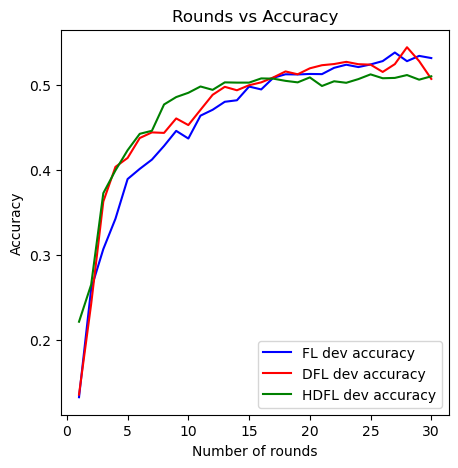

In [26]:
plt.plot([i + 1 for i in range(len(history_FL))], [history_FL[i][1] for i in range(len(history_FL))], color='b', label='FL dev accuracy')
plt.plot([i + 1 for i in range(len(history_DFL))], [history_DFL[i][1] for i in range(len(history_DFL))], color='r', label='DFL dev accuracy')
plt.plot([i + 1 for i in range(len(history_HDFL))], [history_HDFL[i][1] for i in range(len(history_HDFL))], color='green', label='HDFL dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()